# 개와 고양이 분류 (사전 학습 모델 VGG19 - 인라인 방식)

이 노트북은 사전 학습된 VGG19 모델을 사용하여 개와 고양이 이미지를 분류합니다. 
**인라인(Inline) 특성 추출** 방식을 사용하여, VGG19의 합성곱 기반(Convolutional Base)과 새로운 분류기를 하나의 모델로 통합합니다.

**장점:**
- 데이터 증강(Data Augmentation)이 원본 이미지에 직접 적용되어 과적합을 효과적으로 방지합니다.
- 전체 프로세스가 단일 모델 학습으로 이루어져 코드가 더 간결합니다.

**단점:**
- 2단계 방식보다 학습 속도가 느립니다 (매 에포크마다 VGG19 특성 추출을 반복해야 함).

## 1. 라이브러리 임포트

In [1]:
import os
import shutil
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, applications
import matplotlib.pyplot as plt

## 2. 데이터 준비

### 2.1. 데이터셋 다운로드 및 손상된 파일 제거

In [2]:
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
zip_path = tf.keras.utils.get_file('kagglecatsanddogs.zip', origin=dataset_url, extract=True)
original_dir = pathlib.Path(zip_path).parent / 'PetImages'

# 손상된 이미지 제거 (파일이 아니거나 읽을 수 없는 파일 포함)
print(f"원본 데이터 경로: {original_dir}")
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = original_dir / folder_name
    if not folder_path.is_dir():
        print(f"경고: '{folder_path}' 디렉토리를 찾을 수 없습니다.")
        continue
    for fname in os.listdir(folder_path):
        fpath = folder_path / fname
        # 파일이 아니면 건너뛰기
        if not fpath.is_file():
            continue
        try:
            with open(fpath, "rb") as fobj:
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        except Exception as e:
            # 파일을 열거나 읽는 데 실패하면 손상된 것으로 간주
            print(f"파일 읽기 오류 {fpath}: {e}")
            is_jfif = False
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"손상되었거나 읽을 수 없는 이미지 {num_skipped}개를 삭제했습니다.")

원본 데이터 경로: C:\Users\Admin\.keras\datasets\PetImages
손상되었거나 읽을 수 없는 이미지 1578개를 삭제했습니다.


### 2.2. 훈련/검증/테스트용 서브셋 생성

In [3]:
new_base_dir = pathlib.Path("./cats_vs_dogs_small_inline")

def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        
        # 재현성을 위해 파일 목록을 정렬
        fnames = sorted(os.listdir(original_dir / category))
        selected_fnames = fnames[start_index:end_index]
        
        for fname in selected_fnames:
            shutil.copyfile(src=original_dir / category / fname, dst=dir / fname)
            
    # 생성된 파일 수 확인
    cat_count = len(os.listdir(new_base_dir / subset_name / 'Cat'))
    dog_count = len(os.listdir(new_base_dir / subset_name / 'Dog'))
    print(f"'{subset_name}' 서브셋 생성 완료: Cats={cat_count}, Dogs={dog_count}")

# 서브셋 디렉토리가 비어있을 경우에만 생성
if not new_base_dir.exists() or not any((new_base_dir / 'train').iterdir()):
    print("훈련, 검증, 테스트 서브셋을 새로 생성합니다...")
    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2000)
else:
    print("서브셋 디렉토리가 이미 존재하여 재생성하지 않습니다.")

훈련, 검증, 테스트 서브셋을 새로 생성합니다...
'train' 서브셋 생성 완료: Cats=1000, Dogs=1000
'validation' 서브셋 생성 완료: Cats=500, Dogs=500
'test' 서브셋 생성 완료: Cats=500, Dogs=500


## 3. 모델 정의 (인라인 방식)

### 3.1. 데이터 증강 및 VGG19 기반 모델 로드

In [4]:
# 데이터 증강 레이어
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
]) 

# VGG19 합성곱 기반 로드
conv_base = applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

# VGG19의 가중치가 훈련 중에 업데이트되지 않도록 동결
conv_base.trainable = False

print(f"VGG19 동결 전 훈련 가능 가중치 수: {len(conv_base.trainable_weights)}")
print(f"VGG19 동결 후 훈련 가능 가중치 수: {len(conv_base.trainable_weights)}")



VGG19 동결 전 훈련 가능 가중치 수: 0
VGG19 동결 후 훈련 가능 가중치 수: 0


### 3.2. 전체 모델 구성

In [8]:
inputs = keras.Input(shape=(180, 180, 3))

# 1. 데이터 증강
x = data_augmentation(inputs)

# 2. VGG19에 맞는 전처리
x = applications.vgg19.preprocess_input(x)

# 3. VGG19 특성 추출
x = conv_base(x)

# 4. 새로운 분류기
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

## 4. 모델 학습

In [10]:
from keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

train_ds = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
validation_ds = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="inline_feature_extraction.keras",
        save_best_only=True,
        save_weights_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_ds,
    epochs=30, # 충분한 학습을 위해 에포크 수 증가
    validation_data=validation_ds,
    callbacks=callbacks
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Epoch 1/30
63/63 [==============================] - 102s 2s/step - loss: 2.2448 - accuracy: 0.8005 - val_loss: 0.5669 - val_accuracy: 0.9360
Epoch 2/30
63/63 [==============================] - 103s 2s/step - loss: 1.5445 - accuracy: 0.8555 - val_loss: 0.4567 - val_accuracy: 0.9490
Epoch 3/30
63/63 [==============================] - 103s 2s/step - loss: 1.1587 - accuracy: 0.8775 - val_loss: 0.4336 - val_accuracy: 0.9540
Epoch 4/30
63/63 [==============================] - 102s 2s/step - loss: 1.2160 - accuracy: 0.8805 - val_loss: 0.4014 - val_accuracy: 0.9530
Epoch 5/30
63/63 [==============================] - 103s 2s/step - loss: 0.9963 - accuracy: 0.9000 - val_loss: 0.3942 - val_accuracy: 0.9570
Epoch 6/30
63/63 [==============================] - 103s 2s/step - loss: 0.9041 - accuracy: 0.9165 - val_loss: 0.3752 - val_accuracy: 0.9550
Epoch 7/30
63/63 [=============

## 5. 학습 결과 시각화

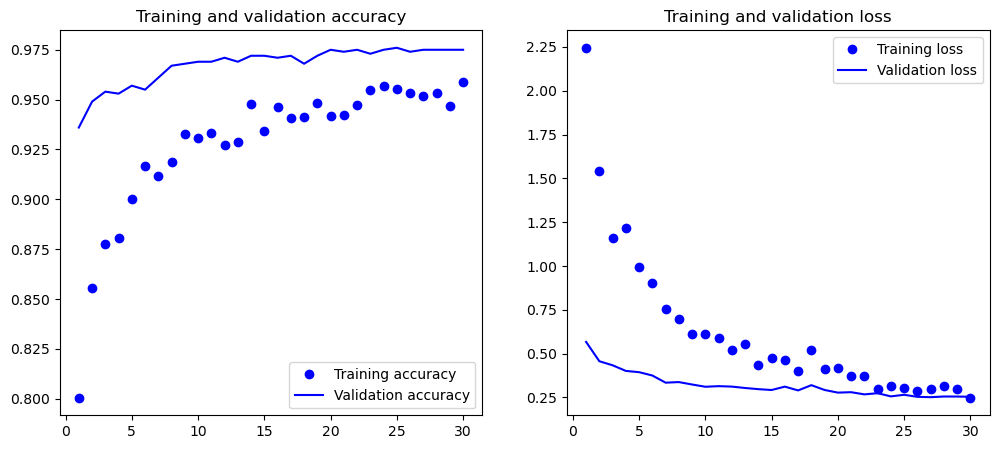

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 6. 모델 평가

In [27]:
# 모델을 먼저 정의해야 합니다.
best_model = keras.Sequential([
    # 모델 구조를 여기에 맞게 정의해야 합니다.
    keras.layers.InputLayer(input_shape=(180,180)),  # 실제 입력 형태로 변경
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# 가중치만 로드합니다.
best_model.load_weights("inline_feature_extraction.keras")

# 테스트 데이터셋으로 최종 모델을 평가합니다.
print("테스트 데이터셋으로 최종 모델을 평가합니다...")
test_loss, test_acc = best_model.evaluate(test_ds)
print(f'테스트 정확도: {test_acc*100:.2f}%')

ValueError: Layer count mismatch when loading weights from file. Model expected 2 layers, found 3 saved layers.